# Label Propagation

In [164]:
import geopandas as gpd
#from shapely.geometry import Point, Polygon
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import rasterio as rs
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rasterio.plot import show


# Input Datasets

In [165]:
ttc = rs.open('../data/testing/CostaRica.tif')
sdpt = gpd.read_file('../data/testing/cri_sdpt_v2.shp')
lulc = rs.open('../data/testing/lulc_cr_reprj.tif')

Text(0.5, 1.0, 'SDPT')

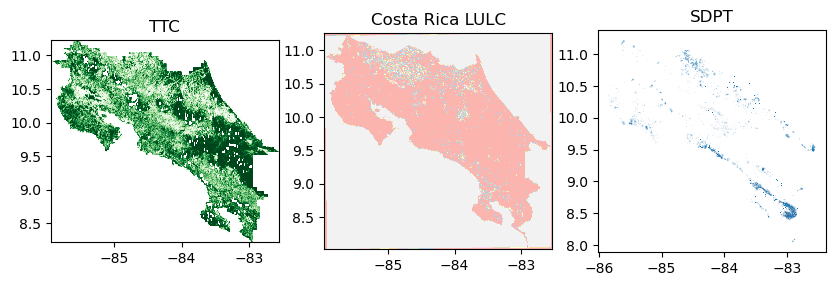

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 8))
show((ttc), cmap='Greens', ax=ax1)
show((lulc), cmap='Pastel1', ax=ax2)
sdpt.plot(ax=ax3)

ax1.set_title("TTC")
ax2.set_title("Costa Rica LULC")
ax3.set_title("SDPT");

## Data Preparation

In [179]:
cr = gpd.read_file('../data/testing/gadm41_CRI_0.shp')
hc_poly = gpd.read_file('../data/testing/HighConf_poly1.shp')
labeled = gpd.read_file('../data/testing/HighConf_Point.shp')
unlabeled = gpd.read_file('../data/testing/output_unlabelledPts.shp')

### Prepare Labeled Points

In [180]:
# clean up column names
labeled.drop(columns=['Id', 'Area', 'gridcode', 'MERGE_SRC', 'ORIG_FID'], inplace=True)
labeled.columns = map(str.lower, labeled.columns)
labeled.rename(columns={'pclass': 'label', 'ttc_thres':'ttc'}, inplace=True)

# clean up vals and dtypes to match what will be extracted
labeled.sdpt = labeled.sdpt.map({'NA': 0.0, 'ForestPlantation': 2.0, 'oilpalm': 1.0, 'orchard': 3.0}).astype('str')
labeled.lulc = labeled.lulc.map({'urban': 10.0, 
                                 'MatureForest': 8.0,
                                 'mangrove':14.0,
                                 'FPlantation':7.0,
                                 'palm':20.0,
                                 'bare':9.0,
                                 'pineapple':22.0,
                                 'coffeeAg':23.0}).astype('str')
labeled.label = labeled.label.map({'notplantation': 0, 'monoculture': 1, 'agroforestry': 2}).astype('str')
labeled.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,20.0,1,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,20.0,1,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,20.0,1,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,20.0,1,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,20.0,1,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


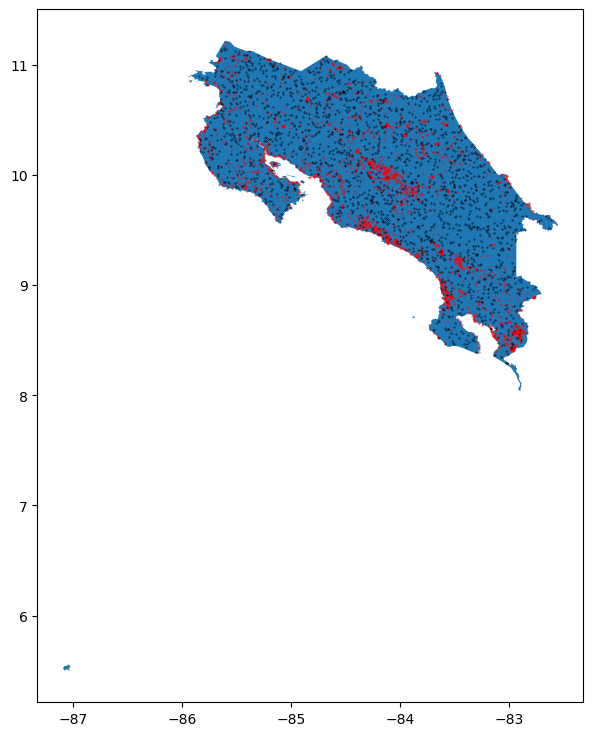

In [168]:
# quick visual to get a sense of the location of labeled and unlabeled points
ax = cr.plot(figsize=(11,9))
labeled.plot(ax=ax, color='red', markersize=0.1)
unlabeled.plot(ax=ax, color='black', markersize=0.1);

In [170]:
## reproject the lulc dataset to espg 4326 to match other input data
## taken verbatim from rasterio documentation w/ added compression params

from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rs.open('../data/testing/lulc_cr.tif') as src:
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'compress': 'lzw',
        'dtype': 'uint8'})

    with rs.open('../data/testing/lulc_cr_reprj.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rs.band(src, i),
                destination=rs.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

### Prepare Unlabeled Points

In [171]:
def extract_raster_values(raster, points):
    
    values = []
    for point in points.geometry:
        x, y = point.x, point.y
        row, col = raster.index(x, y)

        # Check if the point is within the raster extent
        if 0 <= row < raster.height and 0 <= col < raster.width:
            value = raster.read(1, window=((row, row + 1), (col, col + 1)))
            values.append(value[0][0])
        else:
            values.append(np.NaN)
            
    return values


In [181]:
def get_unlabeled_data(num_pts):
    
    '''
    Calculates num_pts within a designated area and extracts associated 
    attributes from 3 rasters. Returns dataframe where each row
    represents an unlabeled observation.
    
    '''
    
    # gets num_pts of unlabeled data
    # for now import Kanchana's generated points
    unlabeled = gpd.read_file('../data/testing/output_unlabelledPts.shp')
    
    # add line to avoid points on cocos island
    # add line to drop any points that are NaN or 255 from TTC or LULC

    # import ttc, sdpt and lulc data and confirm crs
    ttc = rs.open('../data/testing/CostaRica.tif')
    sdpt = gpd.read_file('../data/testing/cri_sdpt_v2.shp')
    lulc = rs.open('../data/testing/lulc_cr_reprj.tif')
    
    assert ttc.crs == sdpt.crs == lulc.crs == unlabeled.crs
    
    # create new df to hold extracted attributes
    df = pd.DataFrame(columns=['lulc', 'label', 'sdpt', 'ttc', 'point_x', 'point_y','geometry'])
    df['geometry'] = unlabeled.geometry
    df['point_x'] = unlabeled.geometry.x
    df['point_y'] = unlabeled.geometry.y
    df['lulc'] = extract_raster_values(lulc, unlabeled)
    df['ttc'] = extract_raster_values(ttc, unlabeled)

    # for sdpt must perform join
    # forest plantations = 2.0, orchard = 7215, oil palm = 1.0
    intersection = gpd.sjoin(unlabeled, sdpt[['originalCo', 'originalNa', 'geometry']], how='left', predicate='within')
    df['sdpt'] = intersection['originalCo']
    
    # take care of null values for modeling
    df['sdpt'] = df['sdpt'].fillna(0)
    df['label'] = df['label'].fillna(-1)
    
    # drop the point on cocos island
    df.drop(index=89, inplace=True)
    
    df[['lulc', 'label', 'sdpt']] = df[['lulc', 'label', 'sdpt']].astype(str)
    df['ttc'] = df['ttc'].astype(np.int64)
    
    return df

In [173]:
unlabeled_df = get_unlabeled_data(unlabeled)
unlabeled_df.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,7.0,-1,0.0,40,-84.483444,10.804541,POINT (-84.48344 10.80454)
1,8.0,-1,0.0,90,-84.434508,9.797179,POINT (-84.43451 9.79718)
2,8.0,-1,0.0,90,-82.612486,9.588960,POINT (-82.61249 9.58896)
3,6.0,-1,0.0,60,-83.161090,9.072028,POINT (-83.16109 9.07203)
4,8.0,-1,0.0,90,-85.567580,10.754863,POINT (-85.56758 10.75486)


## Prepare Model Input

In [215]:
display(labeled.info())
display(unlabeled_df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      2194 non-null   object  
 1   label     2194 non-null   object  
 2   sdpt      2194 non-null   object  
 3   ttc       2194 non-null   int64   
 4   point_x   2194 non-null   float64 
 5   point_y   2194 non-null   float64 
 6   geometry  2194 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 120.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lulc      1999 non-null   object  
 1   label     1999 non-null   int64   
 2   sdpt      1999 non-null   object  
 3   ttc       1999 non-null   int64   
 4   point_x   1999 non-null   float64 
 5   point_y   1999 non-null   float64 
 6   geometry  1999 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 124.9+ KB


None

In [216]:
X = labeled[['lulc','sdpt','ttc','point_x','point_y']]
y = labeled['label']

Xun = unlabeled_df[['lulc','sdpt','ttc','point_x','point_y']]
yun = unlabeled_df['label']

# train test split on labeled data--maintain proportions with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22, stratify=y)

print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', Xun.shape, yun.shape)
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (1645, 5) (1645,)
Unlabeled Train Set: (1999, 5) (1999,)
Test Set: (549, 5) (549,)


## Supervised Learning: Logistic Regression

In [217]:
# apply one hot encoding to all categorical variables
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

cat_cols = ['sdpt', 'lulc']
one_hot = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer([("one-hot-encoder", one_hot, cat_cols)])

superv_model = make_pipeline(preprocessor, LogisticRegression(multi_class='multinomial', solver='sag', max_iter=500, random_state=22))
superv_model.fit(X_train, y_train)
yhat = superv_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

Accuracy: 1.0


## Semi-supervised Learning: Label Propagation

In [219]:
# create the mixed training dataset
X_train_mixed = pd.concat((X_train, Xun))
y_train_mixed = pd.concat((y_train, yun))
display(X_train_mixed.shape, y_train_mixed.shape)
y_train_mixed.value_counts()

(3644, 5)

(3644,)

-1    1999
0     1341
1      238
2       66
Name: label, dtype: int64

In [220]:
# one hot encode
X_train_mixed = pd.get_dummies(X_train_mixed, columns = ['lulc', 'sdpt'])
X_test = pd.get_dummies(X_test, columns = ['lulc', 'sdpt'])

In [222]:
semisuper_model = LabelPropagation()
semisuper_model.fit(X_train_mixed, y_train_mixed)
yhat = semisuper_model.predict(X_test)
score = accuracy_score(y_test, yhat)
print(f'Accuracy: {score}')

## Validation of outputs

In [2]:
preds = gpd.read_file('../data/testing/preds.shp')
preds

,FID,geometry
0,0,POINT (-84.48344 10.80454)
1,1,POINT (-84.43451 9.79718)
2,2,POINT (-82.61249 9.58896)
3,3,POINT (-83.16109 9.07203)
4,4,POINT (-85.56758 10.75486)
...,...,...
1995,1995,POINT (-85.05922 10.96295)
1996,1996,POINT (-83.79055 10.15612)
1997,1997,POINT (-84.04862 10.06536)
1998,1998,POINT (-85.23694 9.77964)


## What Next
Option 1: Could we use the high confidence labeled centroids to generate a 14 x 14 grid of unlabeled points and use label propagation to label the rest of the points in the grid?

Concerns:
- some points are very close and may have overlapping grids which would need to have the same labels
- some degree of photointerpretation still feels necessary
- should pineapple be considered a monoculture plantation? SDPT labels pineapple as orchard

Roadblock
- in qgis cannot reproject to a crs with meters as units (points move to incorrect locations)


In [42]:
# what if we use the labeled points to generate a 14x14 grid of 
# unlabeled points and use label propagation to label each grid
labeled.head()

,lulc,label,sdpt,ttc,point_x,point_y,geometry
0,palm,monoculture,1.0,40,-83.598904,10.540394,POINT (-83.59890 10.54039)
1,palm,monoculture,1.0,40,-83.780329,10.496399,POINT (-83.78033 10.49640)
2,palm,monoculture,1.0,40,-83.798637,10.495866,POINT (-83.79864 10.49587)
3,palm,monoculture,1.0,40,-83.770438,10.491470,POINT (-83.77044 10.49147)
4,palm,monoculture,1.0,40,-83.776915,10.492586,POINT (-83.77692 10.49259)


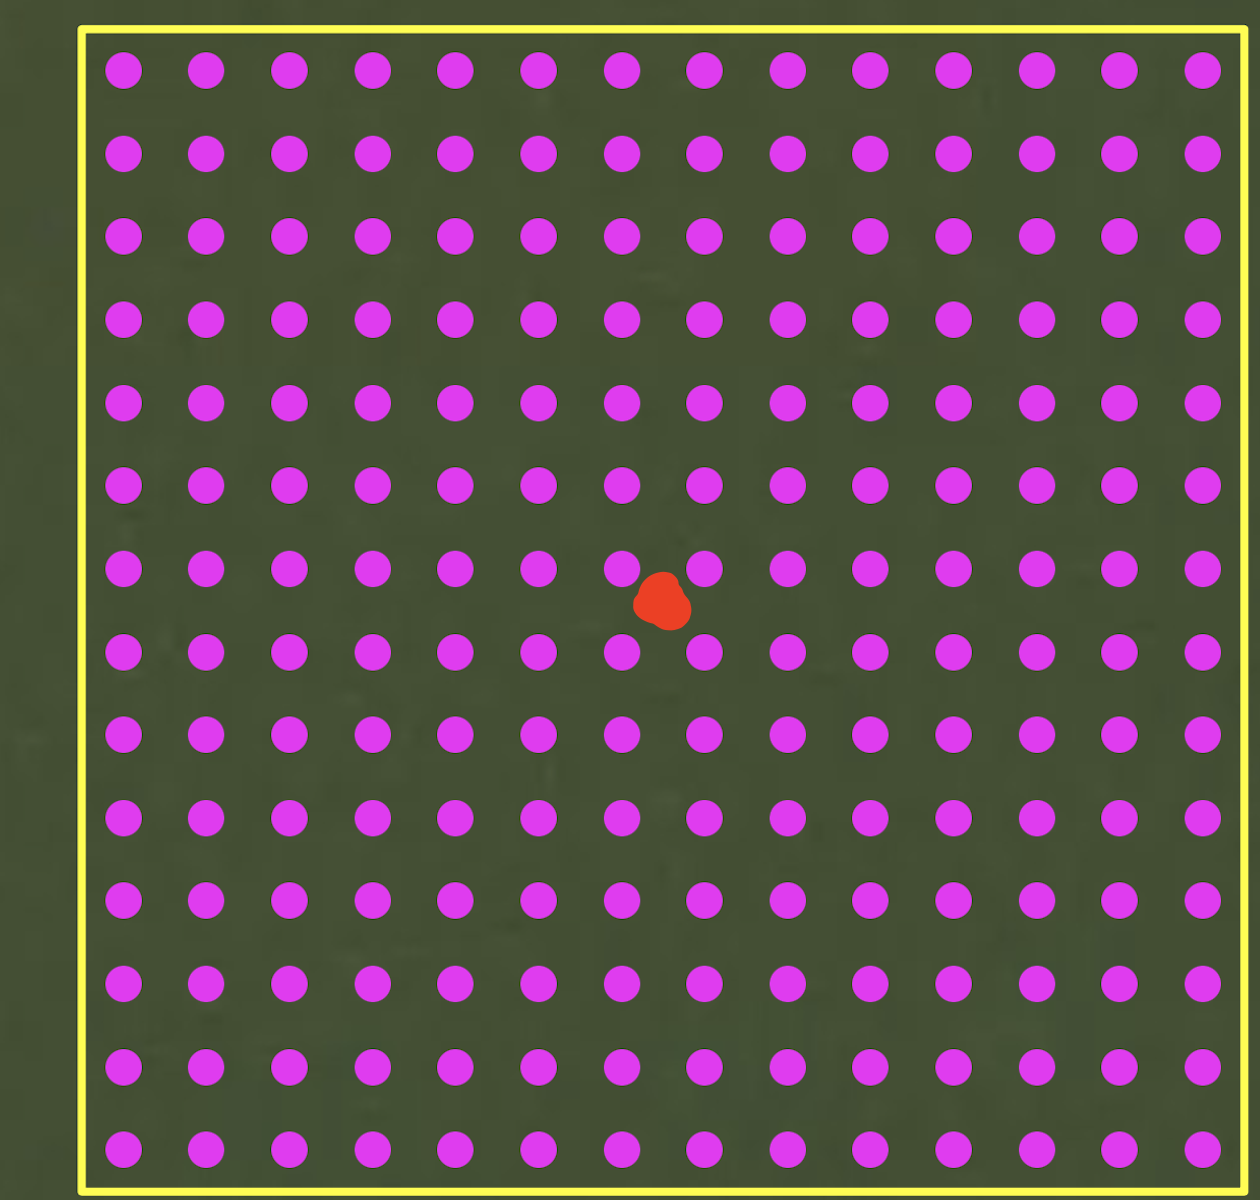